In [9]:
import requests
from urllib.parse import urlencode
import zipfile

import numpy as np
from numpy.linalg import norm

import cv2
import torchvision
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

In [25]:
np.random.seed(42)

# Bag of visual words

## Download data

In [7]:
import requests
from urllib.parse import urlencode

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/vr6SuXgW-8tgbg' # link

final_url = base_url + urlencode (dict (public_key = public_key))
response = requests.get(final_url)
download_url = response.json () [ 'href']
download_response = requests.get (download_url)
with open( 'train.zip', 'wb') as f:
    f.write (download_response.content)

In [10]:
z = zipfile.ZipFile('train.zip')
z.extractall()

## Make dataset

In [26]:
data = torchvision.datasets.ImageFolder('train', transform=torchvision.transforms.Grayscale(3))

## Features extracting with SIFT

In [4]:
extractor = cv2.xfeatures2d.SIFT_create()
keypoints = []
descriptors = []

for img, _ in data:
    img = np.array(img)
    # extract features of every image
    img_keypoints, img_descriptors = extractor.detectAndCompute(img, None)
    keypoints.append(img_keypoints)
    descriptors.append(img_descriptors)

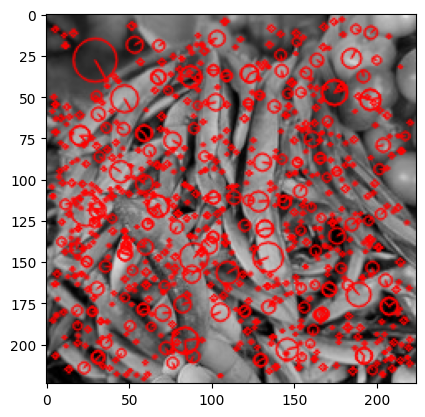

In [5]:
plt.imshow(cv2.drawKeypoints(np.array(data[42][0]), keypoints[42], 0, (255, 0, 0),
                                 flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS));

In [6]:
random_idx = np.random.choice(len(data), 3000, replace=False)

In [7]:
descriptors_sample = []
all_descriptors = []

for n in random_idx:
    descriptors_sample.append(np.array(descriptors[n]))
# make an array of all descriptors
for img_descriptors in descriptors_sample:
    for descriptor in img_descriptors:
        all_descriptors.append(descriptor)

all_descriptors = np.stack(all_descriptors)
all_descriptors.shape

(1160992, 128)

In [35]:
all_descriptors.shape

(1160992, 128)

## Bag of visual words

In [8]:
k_means = KMeans(n_clusters=200, n_init='auto', max_iter=200, random_state=42)

In [9]:
k_means.fit(all_descriptors)

KMeans(max_iter=200, n_clusters=200, n_init='auto', random_state=42)

In [10]:
visual_words = []
for img_descriptors in descriptors:
    img_visual_words = k_means.predict(img_descriptors)
    visual_words.append(img_visual_words) # <-- our bag

## Sparse Frequency Vectors

In [11]:
frequency_vectors = []
for img_visual_words in visual_words:
    # create a frequency vector for each image
    img_frequency_vector = np.zeros(200)
    for word in img_visual_words:
        img_frequency_vector[word] += 1
    frequency_vectors.append(img_frequency_vector)
# stack together in numpy array
frequency_vectors = np.stack(frequency_vectors)

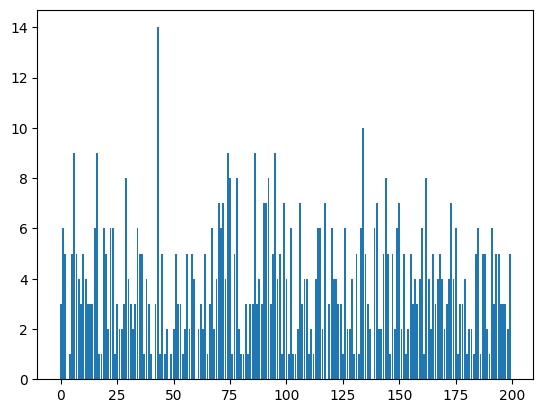

In [12]:
plt.bar(list(range(200)), frequency_vectors[42])
plt.show()

## Tf-idf(term-frequency inverse document frequency)

$tf-idf_{t,d} = tf_{t,d}*idf_t = tf_{t,d} * log\frac{N}{df_t}$, where:

* $tf_{t,d}$ frequency of the visual word $t$ in the image $d$ (the number of times $t$ occurs in $d$)
* $N$ is the total number of images,
* $df_t$ number of images containing visual word $t$
* $log\frac{N}{df_t}$ log measures how common the visual word $t$ is across all images in the database.

In [13]:
N = 15000
dft = np.sum(frequency_vectors > 0, axis=0) # number of images containing visual word t
dft.shape, dft[:5] # How many images contain word 1-5

((200,), array([9654, 9690, 9950, 9765, 9296]))

In [14]:
idf = np.log(N/ dft)
idf.shape, idf[:5]

((200,), array([0.44067786, 0.43695578, 0.41047765, 0.42924564, 0.478466  ]))

In [15]:
# 1st image contain 3 '195' words(value with idx 194 have value 3)
frequency_vectors[0] # <-- tf

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [16]:
tfidf = frequency_vectors * idf
tfidf.shape, tfidf[42][:10]

((15000, 200),
 array([1.32203359, 2.62173465, 2.05238825, 0.        , 0.478466  ,
        2.14776452, 3.61594743, 1.17017996, 1.83419792, 1.51055715]))

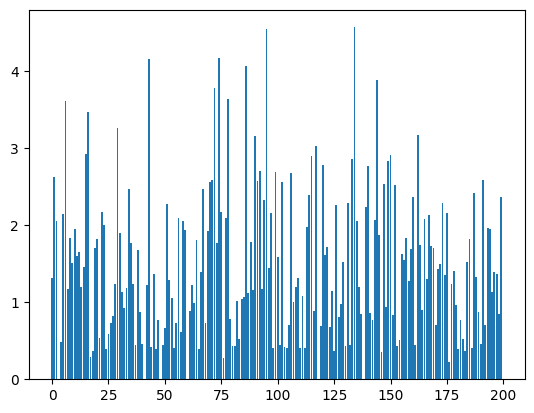

In [17]:
plt.bar(list(range(200)), tfidf[42])
plt.show()

## Search for top-k similar images

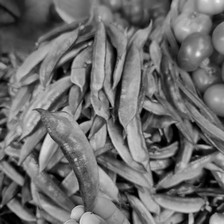

In [18]:
data[42][0]

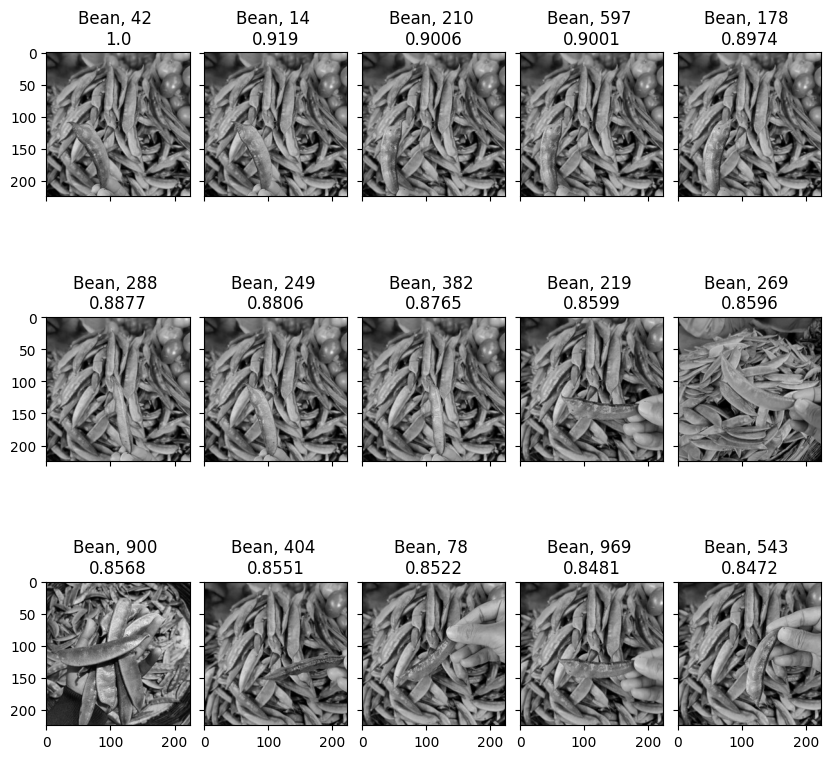

In [23]:
idx_to_classes = {v:k for (k,v) in data.class_to_idx.items()}
top_k = 15
i = 42

# get search image vector
img = tfidf[i]
cosine_similarity = np.dot(img, tfidf.T)/(norm(img) * norm(tfidf, axis=1))

# get the top k indices for most similar vecs
idx = np.argsort(-cosine_similarity)[:top_k]

# display the results

fig, ax = plt.subplots(nrows=3, ncols=5,figsize=(10, 10), \
                        sharey=True, sharex=True)

for i in idx:
    n, = np.where(idx == i)
    img, label = data[i]
    ax[n[0]//5][n[0]%5].imshow(img)
    ax[n[0]//5][n[0]%5].set_title(f"{idx_to_classes[label]}, {i} \n{round(cosine_similarity[i], 4)}")
plt.subplots_adjust(wspace=0.1, hspace=0.1)